In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [10]:
from fastai.conv_learner import *
from fastai.plots import *
from utils import *

In [11]:
print_info()

Last run on: 2018-02-28
PyTorch version: 0.3.1.post2
fastai version: 0.6


In [12]:
PATH = 'data/'
get_cifar10(PATH)

In [13]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [14]:
create_val(os.path.join(PATH, 'cifar10/train'), 0.1)

In [15]:
create_sample(os.path.join(PATH, 'cifar10/train'), 0.01)
create_sample(os.path.join(PATH, 'cifar10/valid'), 0.01)
create_sample(os.path.join(PATH, 'cifar10/test'), 0.01)

In [16]:
def get_data(sz, bs, sample=False):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8, pad_mode=cv2.BORDER_CONSTANT)
    return ImageClassifierData.from_paths(
        f'{PATH}cifar10/',
        trn_name='train' if not sample else 'train_sample',
        val_name='valid' if not sample else 'valid_sample',
        test_name='test'if not sample else 'train_sample',
        tfms=tfms,
        bs=bs,
        test_with_labels=True
    )

In [17]:
bs = 256
sample = False
sz = 32

In [18]:
data = get_data(sz, bs, sample)

## Fully connected model

From a notebook by fastai student [Karem Turgutlu](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb)

In [69]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)
        ])
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for layer in self.layers:
            l_x = layer(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x)

In [74]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40, 10]), data)

In [63]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [64]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [65]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 145/176 [00:10<00:02, 14.25it/s]

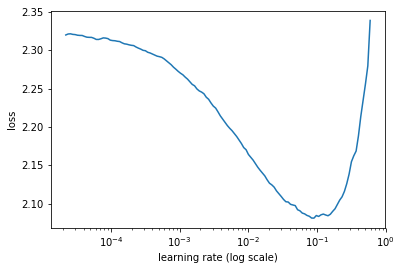

In [66]:
learn.sched.plot()

In [75]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.815248   1.734034   0.394715  
    1      1.715841   1.660614   0.409524        

CPU times: user 36 s, sys: 15.2 s, total: 51.2 s
Wall time: 25 s


[1.660614, 0.40952435731887815]

In [76]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.671294   1.641433   0.432468  
    1      1.641768   1.603395   0.443474        

CPU times: user 36.7 s, sys: 14.6 s, total: 51.3 s
Wall time: 25.1 s


[1.6033955, 0.44347426593303679]

## CNN

In [128]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        layers.insert(0, 3)
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i+1], kernel_size=3, stride=2) for i in range(len(layers)-1)
        ])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.l_out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        return F.log_softmax(self.l_out(x))

In [124]:
learn = ConvLearner.from_model_data(ConvNet([20, 40, 80], 10), data)

In [113]:
learn.model

ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(2, 2))
    (1): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2))
    (2): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (pool): AdaptiveMaxPool2d(output_size=1)
  (l_out): Linear(in_features=80, out_features=10, bias=True)
)

In [114]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      2.337612   2.358285   0.097656  



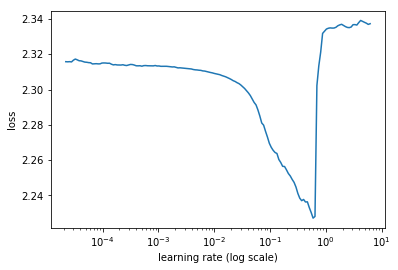

In [115]:
learn.sched.plot()

In [127]:
learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  0%|          | 0/176 [00:00<?, ?it/s]> <ipython-input-123-1e14f50e1920>(18)forward()
     14             x = F.relu(x)
     15         x = self.pool(x)
     16         x = x.view(x.shape[0], -1)
     17         set_trace()
---> 18         return F.log_softmax(self.l_out(x))

ipdb> 



Exception in thread Thread-85:
Traceback (most recent call last):
  File "/home/radek/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/radek/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/radek/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



ipdb> F.log_softmax(self.l_out(x))
Variable containing:
-2.0491 -2.3645 -2.2452  ...  -2.3873 -2.4207 -2.4281
-2.0622 -2.3444 -2.2073  ...  -2.3564 -2.4272 -2.4354
-2.0566 -2.3867 -2.2242  ...  -2.3788 -2.3849 -2.3762
          ...             ⋱             ...          
-2.0760 -2.4041 -2.2687  ...  -2.4387 -2.3677 -2.4237
-2.1147 -2.4470 -2.2184  ...  -2.3481 -2.3748 -2.3532
-2.0542 -2.4162 -2.1944  ...  -2.3540 -2.3215 -2.3944
[torch.cuda.FloatTensor of size 256x10 (GPU 0)]

ipdb> 
Variable containing:
-2.0491 -2.3645 -2.2452  ...  -2.3873 -2.4207 -2.4281
-2.0622 -2.3444 -2.2073  ...  -2.3564 -2.4272 -2.4354
-2.0566 -2.3867 -2.2242  ...  -2.3788 -2.3849 -2.3762
          ...             ⋱             ...          
-2.0760 -2.4041 -2.2687  ...  -2.4387 -2.3677 -2.4237
-2.1147 -2.4470 -2.2184  ...  -2.3481 -2.3748 -2.3532
-2.0542 -2.4162 -2.1944  ...  -2.3540 -2.3215 -2.3944
[torch.cuda.FloatTensor of size 256x10 (GPU 0)]

ipdb> F.log_softmax(self.l_out(x), dim=-1)
Variable containing

BdbQuit: 

In [119]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.370379   1.337397   0.521369  
    1      1.308903   1.287841   0.543934        
    2      1.2769     1.245464   0.556365        
    3      1.230832   1.209976   0.573897        

CPU times: user 1min 15s, sys: 29.4 s, total: 1min 44s
Wall time: 51.2 s


[1.2099756, 0.57389705777168276]

## Refactored

In [140]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        return F.relu(self.conv(x))

In [141]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv_layers = nn.ModuleList([
            ConvLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)
        ])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for layer in self.conv_layers: x = layer(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.shape[0], -1)
        x = self.out(x)
        return F.log_softmax(x)

In [148]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [143]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [149]:
learn, np.sum([o.numel() for o in learn.model.parameters()])

(ConvNet2(
   (conv_layers): ModuleList(
     (0): ConvLayer(
       (conv): Conv2d(3, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     )
     (1): ConvLayer(
       (conv): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     )
     (2): ConvLayer(
       (conv): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     )
   )
   (out): Linear(in_features=80, out_features=10, bias=True)
 ), 37490)

In [150]:
%time learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.777986   1.63073    0.390039  
    1      1.572971   1.525083   0.438557        

CPU times: user 37.4 s, sys: 15.2 s, total: 52.6 s
Wall time: 25.7 s


[1.5250833, 0.43855698555707934]

In [151]:
%time learn.fit(1e-1, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.402017   1.373703   0.49776   
    1      1.353078   1.309317   0.526746        

CPU times: user 37.3 s, sys: 14.9 s, total: 52.2 s
Wall time: 25.5 s


[1.3093166, 0.52674632370471952]

## Batch Norm

In [152]:
from IPython.core.debugger import set_trace

In [223]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size, stride, padding=1, bias=False)
        self.a = nn.Parameter(torch.zeros(nf, 1, 1))
        self.m = nn.Parameter(torch.ones(nf, 1, 1))
    
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0, 1).contiguous().view(x.shape[1], -1)
        if self.training:
            self.means = x_chan.mean(1)[:, None, None]
            self.stds = x_chan.std(1)[:, None, None]
        return (x - self.means) / self.stds * self.m + self.a

In [224]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.shape[0], -1)
        x = self.out(x)
        return F.log_softmax(x)
        

In [225]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [226]:
learn.fit(3e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.589213   1.538288   0.446829  
    1      1.393342   1.261483   0.552229        



[1.2614827, 0.55222885906696317]

In [229]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.323952   1.220455   0.566705  
    1      1.176521   1.061893   0.633375        
    2      1.070975   0.964913   0.664809        
    3      0.994748   0.907815   0.690591        

CPU times: user 1min 17s, sys: 29.1 s, total: 1min 46s
Wall time: 51.4 s


[0.90781516, 0.69059053361415867]

In [230]:
%time learn.fit(1e-2, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.90485    0.864697   0.699816  
    1      0.890279   0.856413   0.707422        
    2      0.869967   0.836291   0.712626        
    3      0.854574   0.824421   0.71543         

CPU times: user 1min 18s, sys: 29.9 s, total: 1min 48s
Wall time: 52 s


[0.82442075, 0.71542968750000002]

## Deep BatchNorm

In [255]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5, padding=2)
        self.layers1 = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        for l1, l2 in zip(self.layers1, self.layers2):
            x = l1(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.shape[0], -1)
        x = self.out(x)
        return F.log_softmax(x)

In [256]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [258]:
%time learn.fit(3e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.611595   1.547349   0.456032  
    1      1.408553   1.324065   0.531376        

CPU times: user 41.2 s, sys: 14.4 s, total: 55.6 s
Wall time: 27.5 s


[1.3240651, 0.53137637972831731]

In [259]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.296573   1.149783   0.593302  
    1      1.166588   1.037562   0.634444        
    2      1.054883   0.948624   0.664993        
    3      0.973495   0.870705   0.691992        

CPU times: user 1min 22s, sys: 28.4 s, total: 1min 50s
Wall time: 54.8 s


[0.87070495, 0.69199218750000002]

In [260]:
%time learn.fit(1e-2, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.896183   0.834289   0.698713  
    1      0.861255   0.83438    0.700977        
    2      0.848104   0.813686   0.707767        
    3      0.827936   0.805872   0.713017        

CPU times: user 1min 20s, sys: 29.2 s, total: 1min 50s
Wall time: 54.3 s


[0.80587196, 0.71301700472831731]

In [262]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('BnLayer-5',
              OrderedDict

## Resnet

This is the resnet model as implemented in fastai lesson 7 [notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-cifar10.ipynb). It is a really interesting version highlighting the key points while offering a slight simplification (we are not using shortcuts across blocks but have skip layer connections across individual layers, also not all layers have these - this way we don't have to worry about changes to dimensionality)

In [263]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [273]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5, 1, padding=2)
        self.layers1 = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers)-1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
            for i in range(len(layers)-1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
            for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l1, l2, l3 in zip(self.layers1, self.layers2, self.layers3):
            x = l3(l2(l1(x)))
        x = F.adaptive_max_pool2d(x, 1).view(x.shape[0], -1)
        x = self.out(x)
        return F.log_softmax(x)

In [291]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [292]:
wd=1e-5

In [293]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 30%|██▉       | 52/176 [00:07<00:19,  6.51it/s]

Exception in thread Thread-188:
Traceback (most recent call last):
  File "/home/radek/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/radek/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/radek/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy        
    0      1.627015   1.5548     0.45378   
    1      1.425162   1.335969   0.525356        

CPU times: user 43.2 s, sys: 14.8 s, total: 58 s
Wall time: 30.1 s


[1.3359692, 0.52535615861415863]

In [294]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.249886   1.186003   0.585099  
    1      1.229403   1.142781   0.601068        
    2      1.1027     1.07408    0.620738        
    3      1.162429   1.10561    0.611121        
    4      1.050975   1.002166   0.6473          
    5      0.946638   0.917581   0.681204        
    6      0.891561   0.912862   0.684972        

CPU times: user 2min 31s, sys: 52.2 s, total: 3min 23s
Wall time: 1min 45s


[0.91286248, 0.68497242629528043]

In [295]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=32), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.010508   0.995416   0.657812  
    1      0.903123   0.867581   0.697645        
    2      0.817155   0.806663   0.721657        
    3      0.775565   0.8035     0.720335        
    4      0.865713   0.867063   0.696967        
    5      0.795684   0.785423   0.729423        
    6      0.706617   0.729066   0.750678        
    7      0.66581    0.724963   0.751884        
    8      0.768962   0.765685   0.734582        
    9      0.703812   0.71644    0.750471        
    10     0.627584   0.68053    0.767279        
    11     0.593135   0.670861   0.77099         
    12     0.707174   0.730261   0.749908        
    13     0.628684   0.689788   0.765384        
    14     0.566665   0.630109   0.780193        
    15     0.516875   0.633232   0.783479        
    16     0.632616   0.685618   0.769899        
    17     0.58403    0.638131   0.783973        
    18     0.515709   0.613479   0.797185        
    19

[0.57290292, 0.80849034786224361]

## Resnet 20 as in the original paper

This is my take on the Resnet-20 from [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) by Kaiming He et al. To confirm my understanding of the skip layer connections I looked at Yerlan Idelbayev's [implementation](https://github.com/akamaster/pytorch_resnet_cifar10)

The paper mentions a result for a non resnet model of similar architecture, so building it is what I will start with. I should be able to train it to around 10% error rate on the test set.

In [405]:
class ConvNet20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv_sz32 = nn.Sequential(
            self.conv_block(16, 16),
            self.conv_block(16, 16),
            self.conv_block(16, 16),
        )
        self.bn_sz32 = nn.BatchNorm2d(16)
        
        self.conv_sz16 = nn.Sequential(
            self.conv_block(16, 32, 2),
            self.conv_block(32, 32),
            self.conv_block(32, 32),
        )
        self.bn_sz16 = nn.BatchNorm2d(32)
                
        self.conv_sz8 = nn.Sequential(
            self.conv_block(32, 64, 2),
            self.conv_block(64, 64),
            self.conv_block(64, 64),
        )
        self.bn_sz8 = nn.BatchNorm2d(64)
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        
        x = self.conv_sz32(x)
        x = F.relu(x)
        x = self.bn_sz32(x)
        
        x = self.conv_sz16(x)
        x = F.relu(x)
        x = self.bn_sz16(x)
        
        x = self.conv_sz8(x)
        x = F.relu(x)
        x = self.bn_sz8(x)
        
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.out(x)
        
        return F.log_softmax(x)
    
    def conv_block(self, ni, no, initial_stride=1):
        return nn.Sequential(
            nn.Conv2d(ni, no, 3, padding=1, bias=False, stride=initial_stride),
            nn.ReLU(),
            nn.BatchNorm2d(no),
            nn.Conv2d(no, no, 3, padding=1, bias=False)
        )

In [406]:
learn = ConvLearner.from_model_data(ConvNet20(), data)

In [407]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 432)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 2304)])),
             ('ReLU-4',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('nb_params', 0)])),
             ('BatchNorm2d-5',
              Ordered

In [408]:
np.sum([o.numel() for o in learn.model.parameters()])

269274

In [49]:
wd = 1e-4

In [410]:
%time learn.fit(0.1, 91, wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=91), HTML(value='')))

 51%|█████     | 89/176 [00:07<00:07, 11.63it/s]

Exception in thread Thread-335:
Traceback (most recent call last):
  File "/home/radek/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/radek/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/radek/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy        
    0      1.764424   1.807509   0.337718  
    1      1.58097    1.624343   0.407778        
    2      1.450453   1.516669   0.462155        
    3      1.340899   1.314045   0.533996        
    4      1.217976   1.281944   0.542682        
    5      1.125525   1.196676   0.554205        
    6      1.029373   1.204094   0.587293        
    7      0.952631   0.984959   0.647587        
    8      0.894612   1.03252    0.642142        
    9      0.858335   0.867485   0.697852        
    10     0.79606    0.850154   0.715464        
    11     0.755315   0.934716   0.683548        
    12     0.719865   0.796178   0.728068        
    13     0.689435   0.796086   0.733536        
    14     0.668266   0.757817   0.738798        
    15     0.644604   0.746039   0.743405        
    16     0.63301    0.671269   0.776379        
    17     0.596379   0.753812   0.750931        
    18     0.580103   0.640953   0.782767        
    19

[0.46936798, 0.85237821638584133]

In [411]:
%time learn.fit(1e-2, 45, wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=45), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.197255   0.340206   0.889832  
    1      0.177336   0.341679   0.889292        
    2      0.170184   0.343211   0.890051        
    3      0.164205   0.348146   0.888534        
    4      0.15454    0.351982   0.88912         
    5      0.153716   0.34671    0.886018        
    6      0.149854   0.350465   0.889315        
    7      0.145639   0.348143   0.89105         
    8      0.148226   0.350342   0.889637        
    9      0.139488   0.354603   0.889901        
    10     0.137389   0.355831   0.888557        
    11     0.141085   0.361287   0.88966         
    12     0.129815   0.359175   0.890947        
    13     0.131471   0.364987   0.890901        
    14     0.12708    0.364369   0.890361        
    15     0.128731   0.360671   0.888534        
    16     0.125278   0.375008   0.884846        
    17     0.130269   0.370258   0.88704         
    18     0.122487   0.377815   0.889269        
    19

[0.42660308, 0.88262867629528041]

In [412]:
%time learn.fit(1e-3, 45, wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=45), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.091542   0.416091   0.88619   
    1      0.086538   0.416331   0.887362        
    2      0.084004   0.419459   0.884628        
    3      0.084365   0.412448   0.887948        
    4      0.08233    0.41294    0.888534        
    5      0.083735   0.415354   0.888339        
    6      0.083106   0.416497   0.88619         
    7      0.083616   0.414971   0.887557        
    8      0.080715   0.414318   0.885604        
    9      0.082281   0.419471   0.887339        
    10     0.080764   0.418656   0.888534        
    11     0.082339   0.420051   0.886386        
    12     0.079347   0.419791   0.890487        
    13     0.0807     0.418792   0.887362        
    14     0.083549   0.419302   0.887167        
    15     0.081056   0.421359   0.887144        
    16     0.07909    0.420373   0.8858          
    17     0.076888   0.420996   0.885214        
    18     0.082005   0.420781   0.885972        
    19

[0.43122029, 0.88616727888584135]

In [417]:
learn.save('conv_net_20')

In [413]:
accuracy_np(*learn.predict_with_targs(is_test=True))

0.8871

In [423]:
log_preds,y = learn.TTA(is_test=True)
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.90110000000000001

The paper reports test error of just under 10% without TTA so the results are in the correct ballpark. The number of parameters also seems okay.

Moving onto Resnet20

In [45]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        initial_stride = 1 if ni == no else 2
        self.conv1 = nn.Conv2d(ni, no, 3, padding=1, bias=False, stride=initial_stride)
        self.bn1 = nn.BatchNorm2d(no)
        self.conv2 = nn.Conv2d(no, no, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(no)
        self.shortcut = self.get_shortcut(ni, no)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.bn1(out)
        
        out = self.conv2(out)
        out = out + self.shortcut(x)
        out = F.relu(out)
        out = self.bn2(out)
        return out

    def get_shortcut(self, ni, no):
        if ni == no: return lambda x: x
        return lambda x: F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, no//4, no//4), "constant", 0)

In [46]:
class Resnet20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv_sz32 = nn.Sequential(
            ConvBlock(16, 16),
            ConvBlock(16, 16),
            ConvBlock(16, 16),
        )
        
        self.conv_sz16 = nn.Sequential(
            ConvBlock(16, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
        )
                
        self.conv_sz8 = nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
        )
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        
        x = self.conv_sz32(x)
        x = self.conv_sz16(x)
        x = self.conv_sz8(x)
        
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.out(x)
        
        return F.log_softmax(x)
    
    def conv_block(self, ni, no, initial_stride=1):
        return nn.Sequential(
            nn.Conv2d(ni, no, 3, padding=1, bias=False, stride=initial_stride),
            nn.ReLU(),
            nn.BatchNorm2d(no),
            nn.Conv2d(no, no, 3, padding=1, bias=False)
        )

In [51]:
learn = ConvLearner.from_model_data(Resnet20(), data)

In [50]:
np.sum([o.numel() for o in learn.model.parameters()])

269722

In [52]:
%time learn.fit(0.1, 91, wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=91), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      1.475456   1.512915   0.461834  
    1      1.134402   1.192573   0.586615        
    2      0.961062   1.11166    0.61736         
    3      0.82719    0.847379   0.708284        
    4      0.728611   0.870132   0.703688        
    5      0.68552    0.72559    0.749138        
    6      0.624721   0.737766   0.746082        
    7      0.578274   0.642062   0.776585        
    8      0.554314   0.652344   0.777734        
    9      0.507382   0.627087   0.791831        
    10     0.491715   0.604422   0.79923         
    11     0.480068   0.594764   0.79884         
    12     0.465572   0.695039   0.768784        
    13     0.446349   0.537606   0.817371        
    14     0.428138   0.537791   0.818888        
    15     0.41319    0.57453    0.809777        
    16     0.404278   0.543117   0.819864        
    17     0.388414   0.505009   0.834605        
    18     0.381639   0.502924   0.834616        
    19

[0.44295287, 0.87472426593303676]

In [53]:
%time learn.fit(1e-2, 45, wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=45), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.097369   0.346058   0.894933  
    1      0.079873   0.3498     0.894715        
    2      0.070254   0.347406   0.898771        
    3      0.066711   0.352402   0.898254        
    4      0.065342   0.355267   0.898817        
    5      0.057232   0.36067    0.89977         
    6      0.056776   0.356819   0.899793        
    7      0.056349   0.358762   0.901942        
    8      0.052319   0.360658   0.899403        
    9      0.050146   0.365653   0.899793        
    10     0.04673    0.367425   0.89923         
    11     0.044902   0.369169   0.901183        
    12     0.042939   0.379125   0.89938         
    13     0.040126   0.375541   0.900965        
    14     0.04206    0.378844   0.900333        
    15     0.040503   0.379802   0.902114        
    16     0.039588   0.379281   0.902677        
    17     0.039253   0.387088   0.900207        
    18     0.037465   0.388607   0.900161        
    19

[0.42987329, 0.90309053361415859]

In [54]:
%time learn.fit(1e-3, 45, wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=45), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.02101    0.430785   0.901333  
    1      0.019884   0.429129   0.902918        
    2      0.021076   0.43082    0.901746        
    3      0.018727   0.43232    0.901942        
    4      0.020237   0.431528   0.901505        
    5      0.01909    0.432533   0.9027          
    6      0.019231   0.42905    0.902505        
    7      0.018246   0.43302    0.902114        
    8      0.019312   0.430881   0.902677        
    9      0.019577   0.432589   0.903286        
    10     0.017716   0.430369   0.901919        
    11     0.018432   0.430812   0.901137        
    12     0.018933   0.435835   0.902895        
    13     0.018108   0.432159   0.903091        
    14     0.018306   0.42867    0.902895        
    15     0.018919   0.430392   0.901919        
    16     0.017968   0.431169   0.902677        
    17     0.017605   0.430533   0.901723        
    18     0.018116   0.430775   0.9027          
    19

[0.4341104, 0.89901194870471957]

In [55]:
learn.save('resnet_20')

In [56]:
accuracy_np(*learn.predict_with_targs(is_test=True))

0.90510000000000002

In [57]:
log_preds,y = learn.TTA(is_test=True)
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.91639999999999999

The model is overfitting quite severly. The difference between my implementation and what I believe was done in the paper is where I put batch norm. In the paper batch norm is likely placed before relu and I place it after.

This could account for the discrepancy in performance. Or I could have gotten particularly unlucky on the training. No point reading too much into this without further experimentation.